In [46]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Input
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

In [3]:
!wget -nc https://archive.org/download/fruits-360/fruits-360.zip

--2024-04-19 05:02:35--  https://archive.org/download/fruits-360/fruits-360.zip
Resolving archive.org (archive.org)... 207.241.224.2
Connecting to archive.org (archive.org)|207.241.224.2|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://ia801203.us.archive.org/24/items/fruits-360/fruits-360.zip [following]
--2024-04-19 05:02:36--  https://ia801203.us.archive.org/24/items/fruits-360/fruits-360.zip
Resolving ia801203.us.archive.org (ia801203.us.archive.org)... 207.241.228.23
Connecting to ia801203.us.archive.org (ia801203.us.archive.org)|207.241.228.23|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 190820824 (182M) [application/zip]
Saving to: ‘fruits-360.zip’

fruits-360.zip      100%[===================>] 181.98M  1.22MB/s    in 98s     

2024-04-19 05:04:15 (1.86 MB/s) - ‘fruits-360.zip’ saved [190820824/190820824]



In [ ]:
!unzip fruits-360.zip

In [50]:
IMAGE_SIZE = [224, 224]

BATCH_SIZE = 32
EPOCHS = 5

In [37]:
train_path = 'fruits-360/Training'
valid_path = 'fruits-360/Validation'

image_files = glob(train_path + '/*/*.jp*g')
valid_image_files = glob(valid_path + '/*/*.jp*g')

folders = glob(train_path + '/*')

In [38]:
len(folders) # number of classes

60

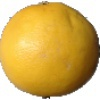

In [58]:
# plot random image
import PIL.Image
PIL.Image.open(np.random.choice(image_files))

In [59]:
gen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=preprocess_input
)

In [60]:
# get labels for confusion matrix mapping

test_gen = gen.flow_from_directory(train_path, target_size=IMAGE_SIZE)
print(test_gen.class_indices)
labels = [None] * len(test_gen.class_indices)
for k, v in test_gen.class_indices.items():
  labels[v] = k

Found 28736 images belonging to 60 classes.
{'Apple Braeburn': 0, 'Apple Golden 1': 1, 'Apple Golden 2': 2, 'Apple Golden 3': 3, 'Apple Granny Smith': 4, 'Apple Red 1': 5, 'Apple Red 2': 6, 'Apple Red 3': 7, 'Apple Red Delicious': 8, 'Apple Red Yellow': 9, 'Apricot': 10, 'Avocado': 11, 'Avocado ripe': 12, 'Banana': 13, 'Banana Red': 14, 'Cactus fruit': 15, 'Carambula': 16, 'Cherry': 17, 'Clementine': 18, 'Cocos': 19, 'Dates': 20, 'Granadilla': 21, 'Grape Pink': 22, 'Grape White': 23, 'Grape White 2': 24, 'Grapefruit Pink': 25, 'Grapefruit White': 26, 'Guava': 27, 'Huckleberry': 28, 'Kaki': 29, 'Kiwi': 30, 'Kumquats': 31, 'Lemon': 32, 'Lemon Meyer': 33, 'Limes': 34, 'Litchi': 35, 'Mandarine': 36, 'Mango': 37, 'Maracuja': 38, 'Nectarine': 39, 'Orange': 40, 'Papaya': 41, 'Passion Fruit': 42, 'Peach': 43, 'Peach Flat': 44, 'Pear': 45, 'Pear Abate': 46, 'Pear Monster': 47, 'Pear Williams': 48, 'Pepino': 49, 'Pineapple': 50, 'Pitahaya Red': 51, 'Plum': 52, 'Pomegranate': 53, 'Quince': 54, 'R

In [52]:
# make train & validation data generators

train_gen = gen.flow_from_directory(
    train_path,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True
)
valid_gen = gen.flow_from_directory(
    valid_path,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True
)

Found 28736 images belonging to 60 classes.
Found 9673 images belonging to 60 classes.


Min: -73.93900299072266, Max: 151.06100463867188
(32, 224, 224, 3)


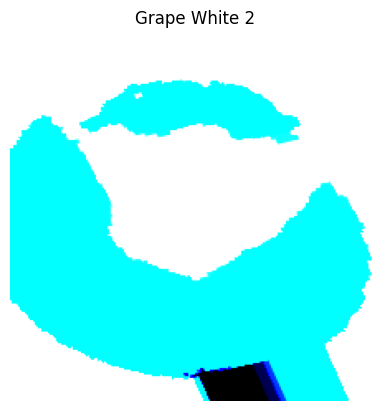

In [72]:
# plot an image from `test_gen` (Should be strangely colored)

for x, y in test_gen:
  print(f"Min: {x[0].min()}, Max: {x[0].max()}")
  print(x.shape)
  plt.title(labels[np.argmax(y[0])])
  plt.imshow(x[0])
  plt.axis(False)
  plt.show()
  break

In [74]:
# create vgg model object

vgg = VGG16(input_shape=IMAGE_SIZE + [3], include_top=False, weights='imagenet')

# freeze all VGG layers
for layer in vgg.layers:
  layer.trainable = False

In [79]:
x = Flatten()(vgg.output)
output = Dense(len(labels), activation='softmax')(x)

fruits_vgg = Model(inputs=vgg.input, outputs=output)

fruits_vgg.compile(loss='categorical_crossentropy',
                   optimizer='rmsprop',
                   metrics=['accuracy'])
fruits_vgg.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [80]:
r = fruits_vgg.fit(
    train_gen,
    epochs=EPOCHS,
    validation_data=valid_gen,
    steps_per_epoch=len(image_files) // BATCH_SIZE,
    validation_steps=len(valid_image_files) // BATCH_SIZE,
)

Epoch 1/5
898/898 [==============================] - 704s 783ms/step - loss: 3.5245 - accuracy: 0.9000 - val_loss: 2.0935 - val_accuracy: 0.9408
Epoch 2/5
898/898 [==============================] - 554s 617ms/step - loss: 0.5478 - accuracy: 0.9797 - val_loss: 2.3291 - val_accuracy: 0.9442
Epoch 3/5
898/898 [==============================] - 516s 575ms/step - loss: 0.2776 - accuracy: 0.9891 - val_loss: 1.1971 - val_accuracy: 0.9664
Epoch 4/5
898/898 [==============================] - 521s 579ms/step - loss: 0.2253 - accuracy: 0.9920 - val_loss: 0.9267 - val_accuracy: 0.9729
Epoch 5/5
898/898 [==============================] - 507s 564ms/step - loss: 0.1961 - accuracy: 0.9932 - val_loss: 1.2058 - val_accuracy: 0.9718


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# function to get confusion matrix from a path to data (because of the use of generators)
def get_confusion_matrix(model, data_path, N):
  print("Generating confusion matrix", N)
  predictions = []
  targets = []
  i = 0
  for x, y in gen.flow_from_directory(data_path, target_size=IMAGE_SIZE, shuffle=False, batch_size=BATCH_SIZE * 2):
    i += 1
    if i % 50 == 0:
      print(i)
    p = model.predict(x)
    p = np.argmax(p, axis=1)
    y = np.argmax(y, axis=1)
    predictions = np.concatenate((predictions, p))
    targets = np.concatenate((targets, y))
    if len(targets) >= N:
      break

  cm = confusion_matrix(targets, predictions)
  return cm

cm = get_confusion_matrix(fruits_vgg, train_path, len(image_files))
valid_cm = get_confusion_matrix(fruits_vgg, valid_path, len(valid_image_files))

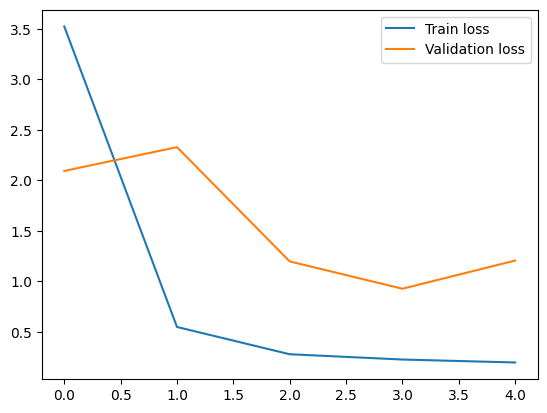

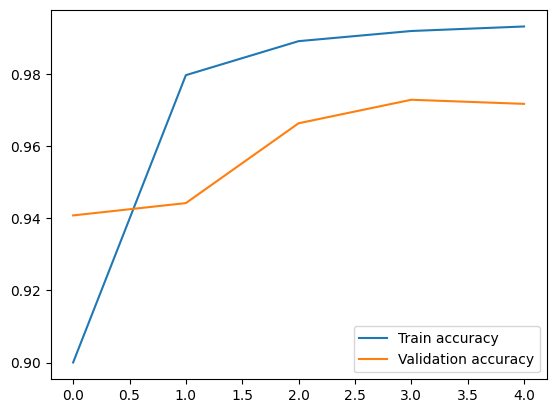

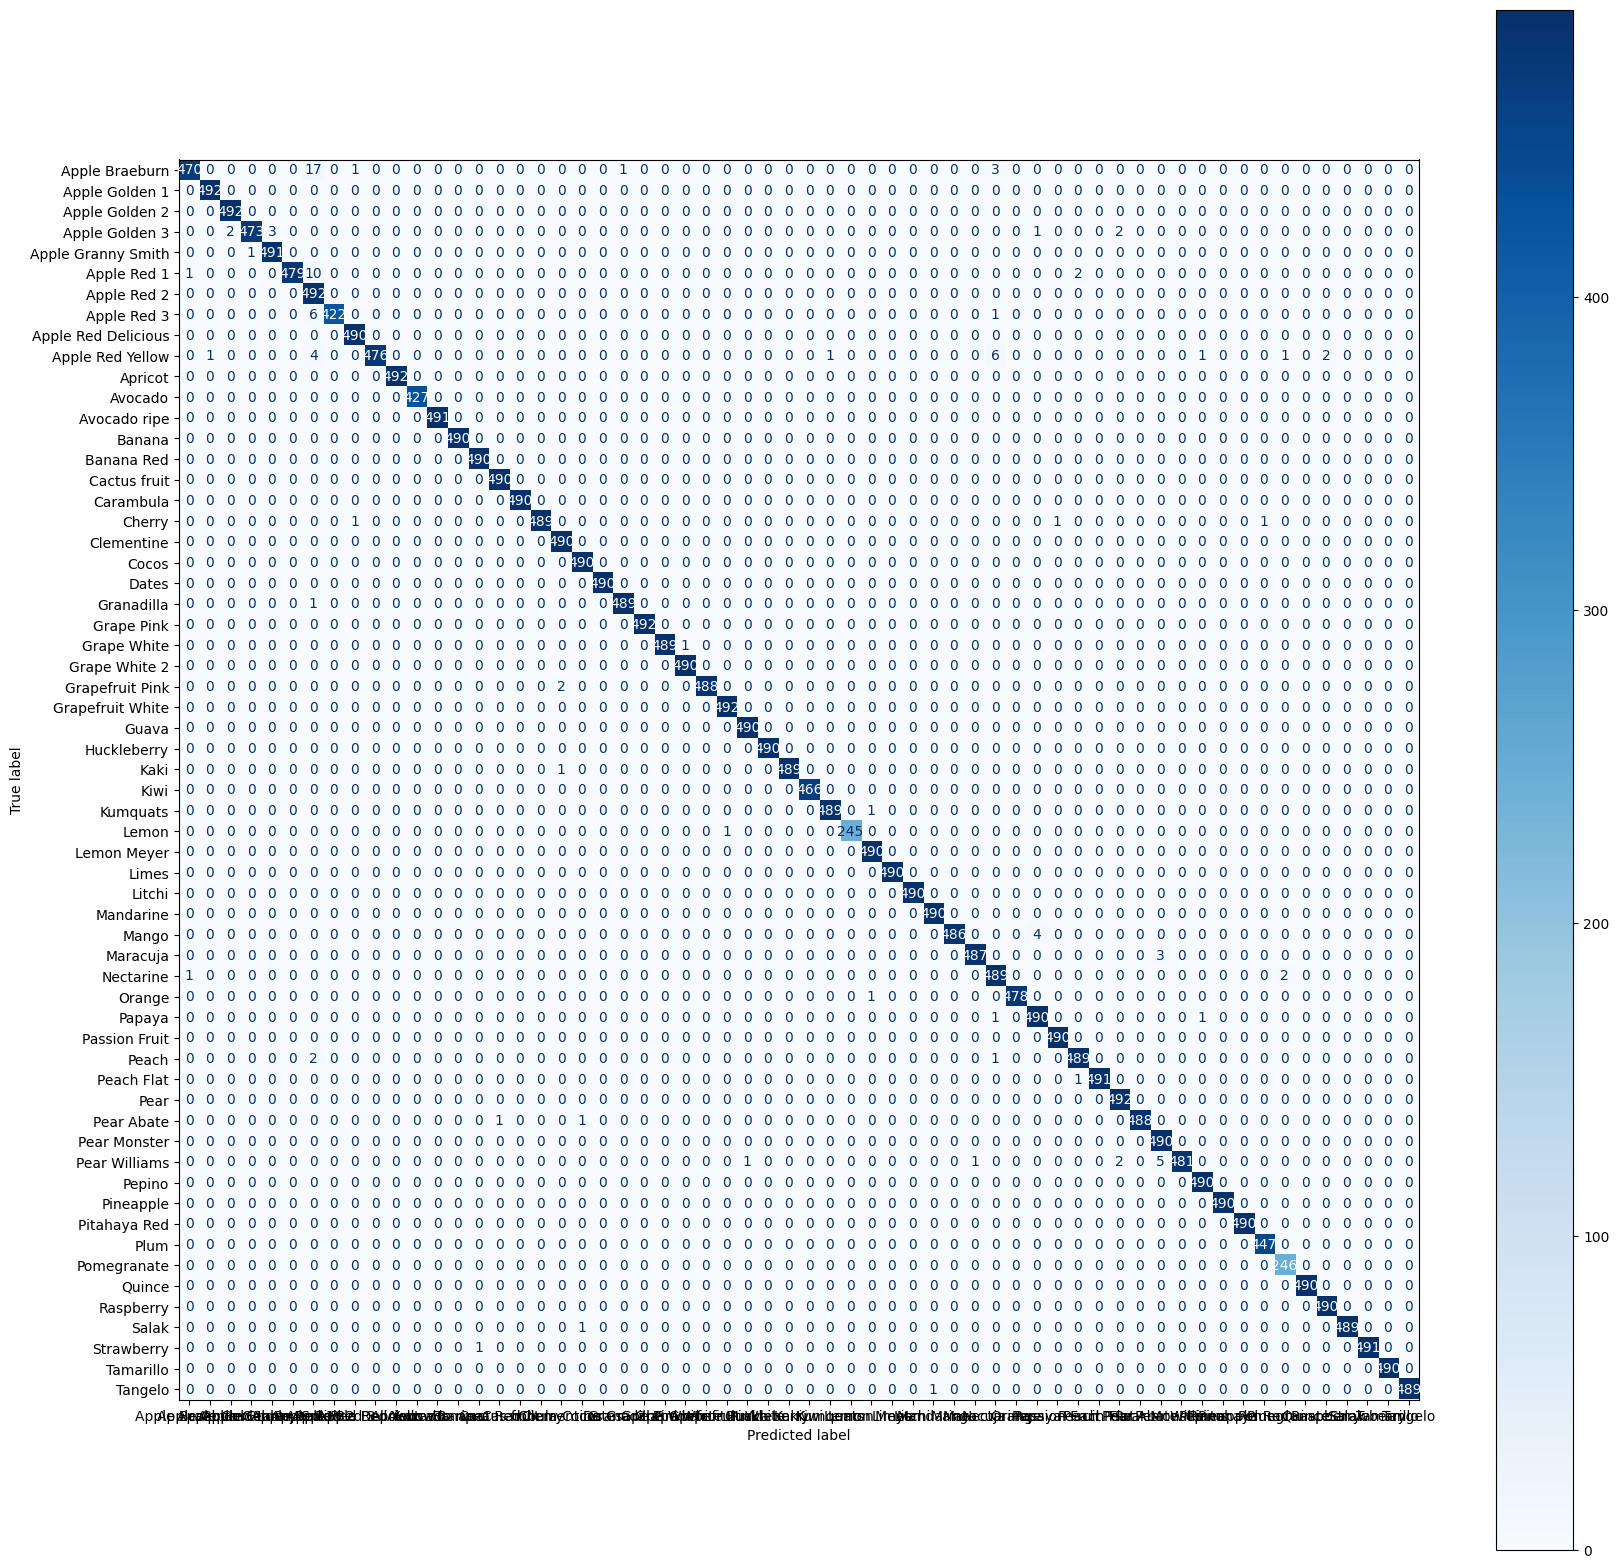

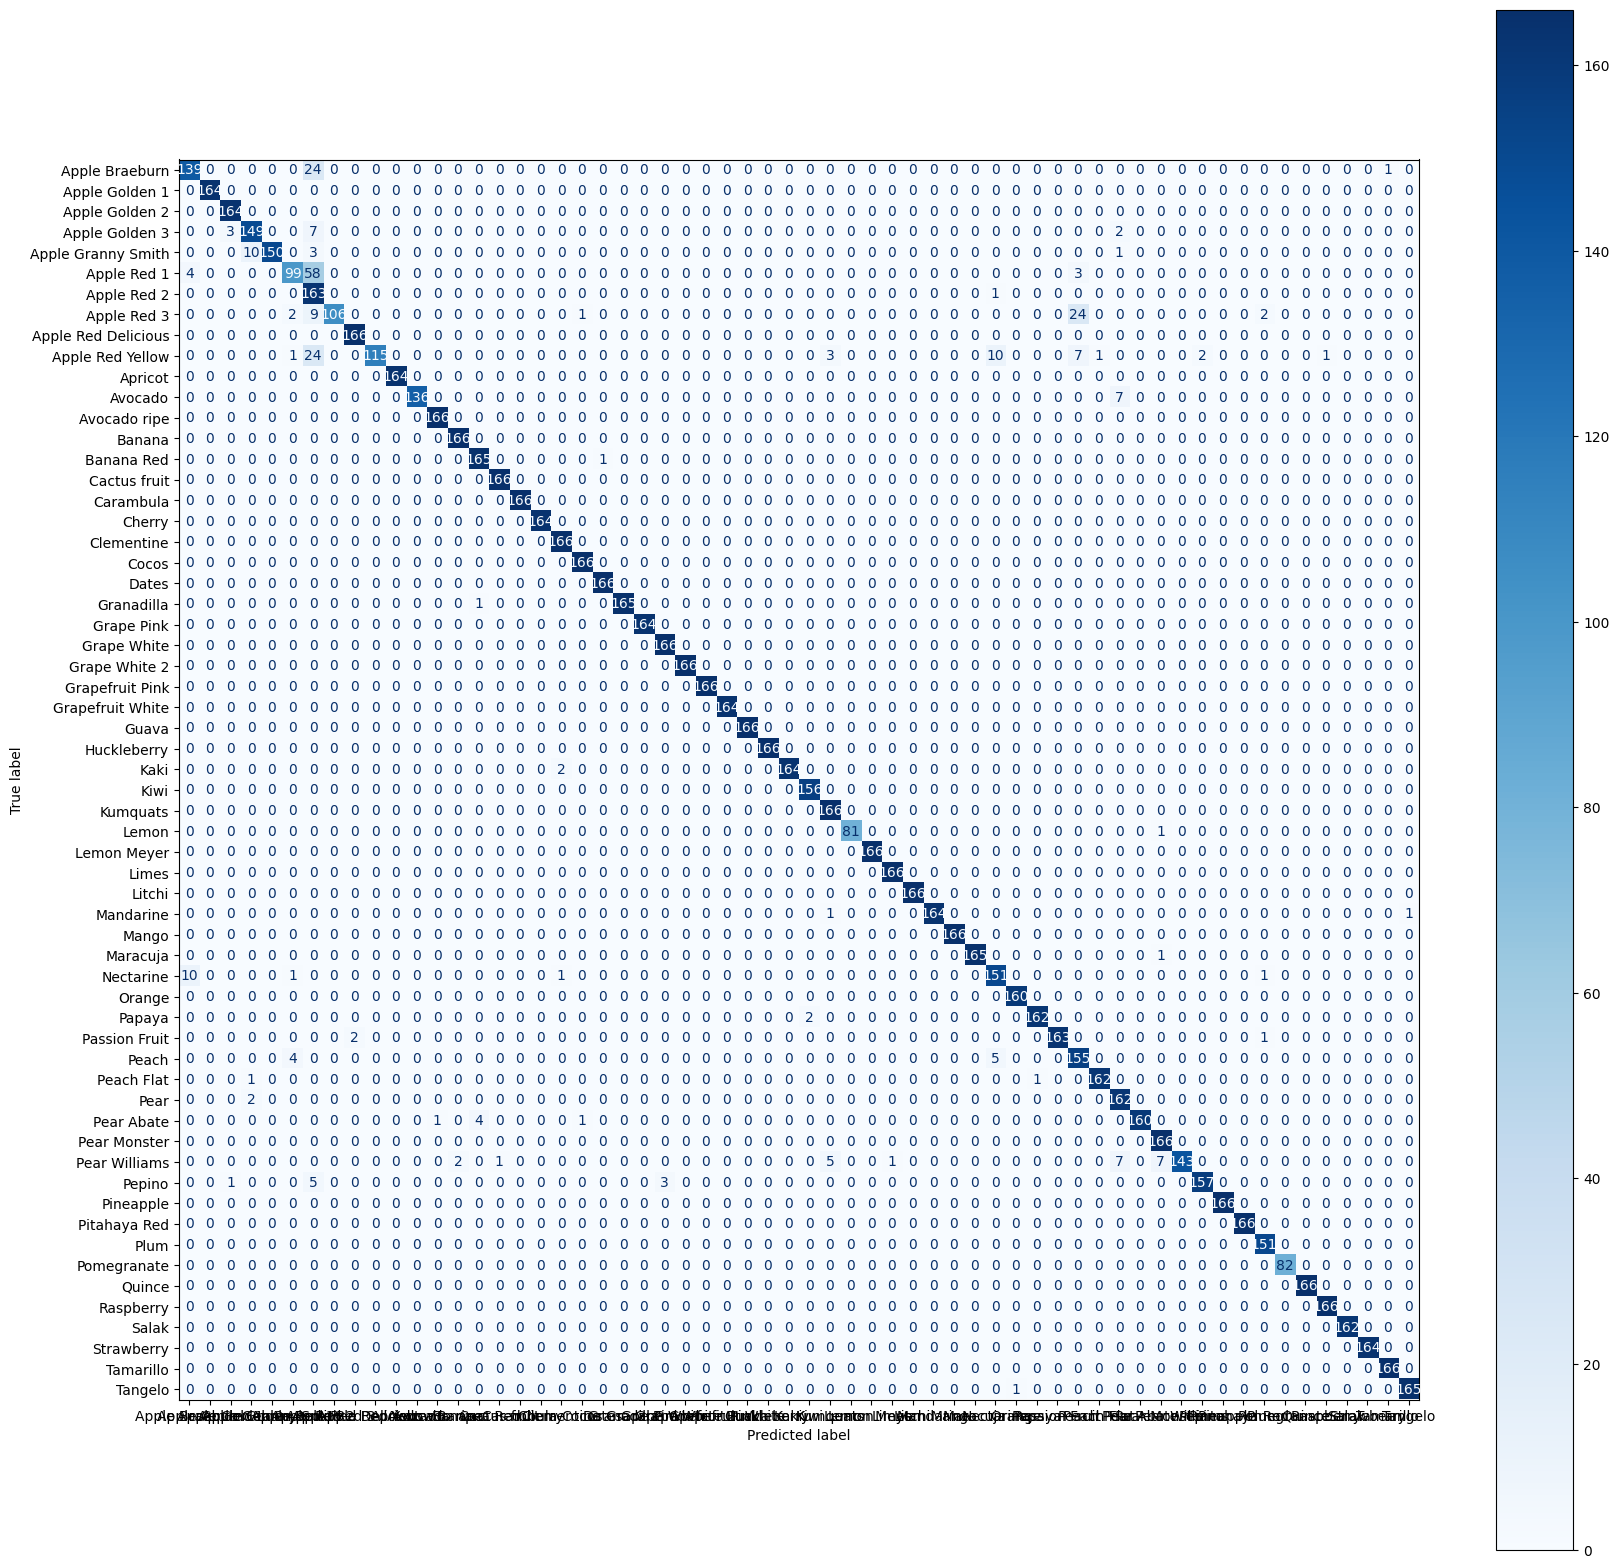

In [97]:
plt.plot(r.history['loss'], label='Train loss')
plt.plot(r.history['val_loss'], label='Validation loss')
plt.legend()
plt.show()

plt.plot(r.history['accuracy'], label='Train accuracy')
plt.plot(r.history['val_accuracy'], label='Validation accuracy')
plt.legend()
plt.show()

fig, ax = plt.subplots(figsize=(20, 20))
train_disp = ConfusionMatrixDisplay(cm, display_labels=labels)
train_disp.plot(cmap=plt.cm.Blues, ax=ax)
plt.show()

fig, ax = plt.subplots(figsize=(20, 20))
val_disp = ConfusionMatrixDisplay(valid_cm, display_labels=labels)
val_disp.plot(cmap=plt.cm.Blues, ax=ax)
plt.show()